## Import Libraries

In [1]:
import torch
from torch import nn
from torchvision import models,transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from tqdm.auto import tqdm

In [2]:
import cv2 as cv

In [3]:
import zipfile

In [4]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 15.5 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## device agnosticode 

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

## load dataset  

In [7]:
!unzip /content/drive/MyDrive/Course/Sem2/DL/Assignment/CelebA_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/197602.jpg  
  inflating: img_align_celeba/197603.jpg  
  inflating: img_align_celeba/197604.jpg  
  inflating: img_align_celeba/197605.jpg  
  inflating: img_align_celeba/197606.jpg  
  inflating: img_align_celeba/197607.jpg  
  inflating: img_align_celeba/197608.jpg  
  inflating: img_align_celeba/197609.jpg  
  inflating: img_align_celeba/197610.jpg  
  inflating: img_align_celeba/197611.jpg  
  inflating: img_align_celeba/197612.jpg  
  inflating: img_align_celeba/197613.jpg  
  inflating: img_align_celeba/197614.jpg  
  inflating: img_align_celeba/197615.jpg  
  inflating: img_align_celeba/197616.jpg  
  inflating: img_align_celeba/197617.jpg  
  inflating: img_align_celeba/197618.jpg  
  inflating: img_align_celeba/197619.jpg  
  inflating: img_align_celeba/197620.jpg  
  inflating: img_align_celeba/197621.jpg  
  inflating: img_align_celeba/197622.jpg  
  inflating: img_align_celeba/197623.jpg  
  i

In [8]:
info = pd.read_csv('list_attr_celeba.txt', sep="\s+", skiprows=1, index_col=0, usecols=['Attractive', 'Bald', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Eyeglasses', 'Mustache', 'No_Beard'])
# info.index.name = 'name'

info.replace(-1, 0, inplace = True)
info

,Attractive,Bald,Big_Nose,Black_Hair,Blond_Hair,Eyeglasses,Mustache,No_Beard
000001.jpg,1,0,0,0,0,0,0,1
000002.jpg,0,0,1,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,0,1
000004.jpg,1,0,0,0,0,0,0,1
000005.jpg,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
202595.jpg,1,0,0,0,1,0,0,1
202596.jpg,0,0,0,0,1,0,0,1
202597.jpg,0,0,0,1,0,1,0,1
202598.jpg,1,0,0,1,0,0,0,1


In [9]:
info.index
# list(info.columns)

Index(['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg',
       '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg',
       ...
       '202590.jpg', '202591.jpg', '202592.jpg', '202593.jpg', '202594.jpg',
       '202595.jpg', '202596.jpg', '202597.jpg', '202598.jpg', '202599.jpg'],
      dtype='object', length=202599)

In [10]:
# class MultiTaskDataset(Dataset):
#     def __init__(self,df, tfms, size=64):
#         self.transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
#         self.root_data = 'img_align_celeba/'
#         self.paths = list(df.index)
#         self.labels = list(df.columns)
#         self.tfms = tfms
#         self.size = size
#         # self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats

#     def __len__(self): return len(self.paths)

#     def __getitem__(self,idx):
#         #dealing with the image
#         img = PIL.Image.open(self.root_data + self.paths[idx]).convert('RGB')
#         img = PIL.Image(PIL.pil2tensor(img, dtype=np.float32).div_(255))
#         img = img.apply_tfms(self.tfms, size = self.size)
#         img = self.norm(img.data)

#         #dealing with the labels
#         labels = self.labels[idx].split(" ")
#         Attractive = torch.tensor(float(labels[0]), dtype=torch.float32)
#         Bald = torch.tensor(int(labels[1]), dtype=torch.float32)
#         Big_Nose = torch.tensor(int(labels[2]), dtype=torch.float32)
#         Black_Hair = torch.tensor(int(labels[3]), dtype=torch.float32)
#         Blond_Hair = torch.tensor(int(labels[4]), dtype=torch.float32)
#         Eyeglasses = torch.tensor(int(labels[5]), dtype=torch.float32)
#         Mustache = torch.tensor(int(labels[6]), dtype=torch.float32)
#         No_Beard = torch.tensor(int(labels[7]), dtype=torch.float32)
        
#         return img.data, (Attractive, Bald, Big_Nose, Black_Hair, Blond_Hair, Eyeglasses, Mustache, No_Beard)


class MultiTaskDataset(Dataset):
    def __init__(self, df):
        self.transform = transforms.Compose([
                                              transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                            ])
        self.image_paths = 'img_align_celeba/'
        self.paths = list(df.index)
        self.labels = list(df.columns)
        self.df = df
        
    def __len__(self):
         return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = PIL.Image.open(self.image_paths + self.paths[idx]).convert('RGB')
        # img = PIL.Image(PIL.pil2tensor(img, dtype=np.float32).div_(255))
        # img = img.apply_tfms(self.tfms, size = self.size)
        # img = self.norm(img.data)
        # img.show()
        img = self.transform(img)

        #dealing with the labels
        labels = self.df.iloc[idx]
        Attractive = torch.tensor(int(labels[0]), dtype=torch.long)
        Bald = torch.tensor(int(labels[1]), dtype=torch.long)
        Big_Nose = torch.tensor(int(labels[2]), dtype=torch.long)
        Black_Hair = torch.tensor(int(labels[3]), dtype=torch.long)
        Blond_Hair = torch.tensor(int(labels[4]), dtype=torch.long)
        Eyeglasses = torch.tensor(int(labels[5]), dtype=torch.long)
        Mustache = torch.tensor(int(labels[6]), dtype=torch.long)
        No_Beard = torch.tensor(int(labels[7]), dtype=torch.long)

        return img, (Attractive, Bald, Big_Nose, Black_Hair, Blond_Hair, Eyeglasses, Mustache, No_Beard)


In [11]:
root_data = "img_align_celeba/"
paths = '000001.jpg'

In [12]:
print(root_data + paths)

img_align_celeba/000001.jpg


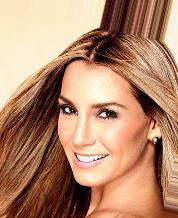

In [13]:
img = PIL.Image.open(root_data + paths).convert('RGB')
# img.show(img)

# img = cv.imread(root_data + paths, cv.IMREAD_UNCHANGED)
# print(img)
img.show()

# img = cv.imread(folder_dir + im, cv.IMREAD_UNCHANGED)


In [14]:
train_data = MultiTaskDataset(info[:75000])
test_data = MultiTaskDataset(info[75000:100000])

In [15]:
type(info[:160000])

pandas.core.frame.DataFrame

In [16]:
# train_data[0]

In [17]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                          batch_size= BATCH_SIZE,
                          shuffle=True) 

test_dataloader = DataLoader(dataset=test_data,
                          batch_size= BATCH_SIZE,
                          shuffle=False)

In [18]:
for i, (x, y) in enumerate(train_dataloader):
  print(x)
  print(y)
  break

tensor([[[[0.5373, 0.5725, 0.5216,  ..., 0.2235, 0.2078, 0.2039],
          [0.4431, 0.5529, 0.5490,  ..., 0.2392, 0.2314, 0.2314],
          [0.3843, 0.5059, 0.5804,  ..., 0.2471, 0.2471, 0.2549],
          ...,
          [0.1804, 0.2471, 0.3490,  ..., 0.4275, 0.4078, 0.4706],
          [0.4235, 0.5686, 0.6471,  ..., 0.3529, 0.5216, 0.6667],
          [0.4118, 0.5529, 0.6235,  ..., 0.6196, 0.7098, 0.7412]],

         [[0.5373, 0.5725, 0.5255,  ..., 0.2392, 0.2235, 0.2353],
          [0.4431, 0.5529, 0.5529,  ..., 0.2549, 0.2471, 0.2549],
          [0.3804, 0.5020, 0.5765,  ..., 0.2627, 0.2627, 0.2784],
          ...,
          [0.4235, 0.4392, 0.4941,  ..., 0.2510, 0.2039, 0.2549],
          [0.5137, 0.6000, 0.6353,  ..., 0.2000, 0.3412, 0.4588],
          [0.4235, 0.5137, 0.5529,  ..., 0.4784, 0.5373, 0.5294]],

         [[0.4353, 0.4627, 0.4000,  ..., 0.1098, 0.0941, 0.0980],
          [0.3490, 0.4510, 0.4392,  ..., 0.1255, 0.1176, 0.1176],
          [0.2980, 0.4196, 0.4863,  ..., 0

## train and test loop

In [19]:
# train
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, 
               accuracy_fn, device: torch.device = device):
  
  train_loss, train_acc = 0, 0
  tr_acc_1, tr_acc_2, tr_acc_3, tr_acc_4, tr_acc_5, tr_acc_6 ,tr_acc_7, tr_acc_8 = 0, 0, 0, 0, 0, 0, 0, 0

  model.train()
  for batch, (x_train, y_train) in enumerate(dataloader):

    # print(type(y_train))
    # print(type(x_train))
    if device == 'cuda':
      x_train = x_train.to(device)
      for i in range(len(y_train)):
        y_train[i] = y_train[i].to(device)

    
    # 1. Forward
    y_pred = model(x_train)

    # 2. Loss
    loss_1 = loss_fn(y_pred[0], y_train[0])
    loss_2 = loss_fn(y_pred[1], y_train[1])
    loss_3 = loss_fn(y_pred[2], y_train[2])
    loss_4 = loss_fn(y_pred[3], y_train[3])
    loss_5 = loss_fn(y_pred[4], y_train[4])
    loss_6 = loss_fn(y_pred[5], y_train[5])
    loss_7 = loss_fn(y_pred[6], y_train[6])
    loss_8 = loss_fn(y_pred[7], y_train[7])


    y_lab = []
    for y in y_pred:
      y_lab.append(torch.argmax(y, dim = 1))

    

    acc_1 = accuracy_fn(y_train[0], y_lab[0])
    acc_2 = accuracy_fn(y_train[1], y_lab[1])
    acc_3 = accuracy_fn(y_train[2], y_lab[2])
    acc_4 = accuracy_fn(y_train[3], y_lab[3])
    acc_5 = accuracy_fn(y_train[4], y_lab[4])
    acc_6 = accuracy_fn(y_train[5], y_lab[5])
    acc_7 = accuracy_fn(y_train[6], y_lab[6])
    acc_8 = accuracy_fn(y_train[7], y_lab[7])

    loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8
    
    # print("train")
    # print(f"acutal: {y_train}")
    # print(f"pred: {torch.argmax(y_pred, dim = 1)}")
    train_loss += loss
    train_acc += ((acc_1 + acc_2 + acc_3 + acc_4 + acc_5 + acc_6 + acc_7 + acc_8)/8)

    tr_acc_1 += acc_1
    tr_acc_2 += acc_2
    tr_acc_3 += acc_3
    tr_acc_4 += acc_4
    tr_acc_5 += acc_5
    tr_acc_6 += acc_6
    tr_acc_7 += acc_7
    tr_acc_8 += acc_8

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  tr_acc_1 /= len(dataloader)
  tr_acc_2 /= len(dataloader)
  tr_acc_3 /= len(dataloader)
  tr_acc_4 /= len(dataloader)
  tr_acc_5 /= len(dataloader)
  tr_acc_6 /= len(dataloader)
  tr_acc_7 /= len(dataloader)
  tr_acc_8 /= len(dataloader)

  print("Train Acuuracy")
  print(f"attribute 1: {tr_acc_1:.4f} attribute 2: {tr_acc_2:.4f} attribute 3: {tr_acc_3:.4f} attribute 4: {tr_acc_4:.4f}")
  print(f"attribute 5: {tr_acc_5:.4f} attribute 6: {tr_acc_6:.4f} attribute 7: {tr_acc_7:.4f} attribute 8: {tr_acc_8:.4f}")
  print()

  return train_loss, train_acc, tr_acc_1, tr_acc_2, tr_acc_3, tr_acc_4, tr_acc_5, tr_acc_6 ,tr_acc_7, tr_acc_8


def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
  test_loss, test_acc = 0, 0
  tt_acc_1, tt_acc_2, tt_acc_3, tt_acc_4, tt_acc_5, tt_acc_6 ,tt_acc_7, tt_acc_8 = 0, 0, 0, 0, 0, 0, 0, 0

  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:
      if device == 'cuda':
        x_test = x_test.to(device)
        for i in range(len(y_test)):
          y_test[i] = y_test[i].to(device)

      # 1. Forward
      test_pred = model(x_test)

      # 2. Loss
      loss_1 = loss_fn(test_pred[0], y_test[0])
      loss_2 = loss_fn(test_pred[1], y_test[1])
      loss_3 = loss_fn(test_pred[2], y_test[2])
      loss_4 = loss_fn(test_pred[3], y_test[3])
      loss_5 = loss_fn(test_pred[4], y_test[4])
      loss_6 = loss_fn(test_pred[5], y_test[5])
      loss_7 = loss_fn(test_pred[6], y_test[6])
      loss_8 = loss_fn(test_pred[7], y_test[7])


      y_test_lab = []
      for y in test_pred:
        y_test_lab.append(torch.argmax(y, dim = 1))

      acc_1 = accuracy_fn(y_test[0], y_test_lab[0])
      acc_2 = accuracy_fn(y_test[1], y_test_lab[1])
      acc_3 = accuracy_fn(y_test[2], y_test_lab[2])
      acc_4 = accuracy_fn(y_test[3], y_test_lab[3])
      acc_5 = accuracy_fn(y_test[4], y_test_lab[4])
      acc_6 = accuracy_fn(y_test[5], y_test_lab[5])
      acc_7 = accuracy_fn(y_test[6], y_test_lab[6])
      acc_8 = accuracy_fn(y_test[7], y_test_lab[7])
      

      loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8

      test_loss += loss

      test_acc += ((acc_1 + acc_2 + acc_3 + acc_4 + acc_5 + acc_6 + acc_7 + acc_8)/8)

      tt_acc_1 += acc_1
      tt_acc_2 += acc_2
      tt_acc_3 += acc_3
      tt_acc_4 += acc_4
      tt_acc_5 += acc_5
      tt_acc_6 += acc_6
      tt_acc_7 += acc_7
      tt_acc_8 += acc_8
      # print("test")
      # print(f"acutal: {y_test}")
      # print(f"pred: {torch.argmax(test_pred, dim = 1)}")

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    tt_acc_1 /= len(dataloader)
    tt_acc_2 /= len(dataloader)
    tt_acc_3 /= len(dataloader)
    tt_acc_4 /= len(dataloader)
    tt_acc_5 /= len(dataloader)
    tt_acc_6 /= len(dataloader)
    tt_acc_7 /= len(dataloader)
    tt_acc_8 /= len(dataloader)

    print("Test Acuuracy")
    print(f"attribute 1: {tt_acc_1:.4f} attribute 2: {tt_acc_2:.4f} attribute 3: {tt_acc_3:.4f} attribute 4: {tt_acc_4:.4f}")
    print(f"attribute 5: {tt_acc_5:.4f} attribute 6: {tt_acc_6:.4f} attribute 7: {tt_acc_7:.4f} attribute 8: {tt_acc_8:.4f}")
    print()

  return test_loss, test_acc, tt_acc_1, tt_acc_2, tt_acc_3, tt_acc_4, tt_acc_5, tt_acc_6 ,tt_acc_7, tt_acc_8

## loss and Accuracy function

In [20]:
# loss
loss_fn = nn.CrossEntropyLoss()

# accuracy
accuracy_fn = MulticlassAccuracy(num_classes = 2).to(device)

## Plot function for Loss and Accuracy 

In [21]:
def plotplot(train_losses, test_losses, train_acces, test_acces):
  plt.figure(figsize = (25,8))
  # plt.plot(range(1, epoches*(len(train_dataloader)*BATCH_SIZE) + 1), train)
  plt.subplot(1,2,1)
  plt.plot(range(len(train_losses)),train_losses, label = "Train Loss")
  plt.plot(range(len(test_losses)),test_losses, label = "Test Loss")
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  plt.title("Loss vs Epoches")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(range(len(train_acces)),train_acces, label = "Train Accuracy")
  plt.plot(range(len(test_acces)),test_acces, label = "Test Accuracy")
  plt.xlabel("Epoches")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epoches")
  plt.legend()

  plt.show()

## Build Model

In [22]:
class MultiTaskModel(nn.Module):
    def __init__(self):
      super().__init__()
      self.resnet18 = models.resnet18(weights="DEFAULT", progress = False).to(device)
      self.n_features = self.resnet18.fc.in_features
      self.resnet18.fc = nn.Identity().to(device)

      self.resnet18.fc0 = nn.Linear(self.n_features, 2).to(device)
      self.resnet18.fc1 = nn.Linear(self.n_features, 2).to(device)
      self.resnet18.fc2 = nn.Linear(self.n_features, 2).to(device)
      self.resnet18.fc3 = nn.Linear(self.n_features, 2).to(device)
      self.resnet18.fc4 = nn.Linear(self.n_features, 2).to(device)
      self.resnet18.fc5 = nn.Linear(self.n_features, 2).to(device)
      self.resnet18.fc6 = nn.Linear(self.n_features, 2).to(device)
      self.resnet18.fc7 = nn.Linear(self.n_features, 2).to(device)

    def forward(self, x):
        attri_0 = self.resnet18.fc0(self.resnet18(x))
        attri_1 = self.resnet18.fc1(self.resnet18(x))
        attri_2 = self.resnet18.fc2(self.resnet18(x))
        attri_3 = self.resnet18.fc3(self.resnet18(x))
        attri_4 = self.resnet18.fc4(self.resnet18(x))
        attri_5 = self.resnet18.fc5(self.resnet18(x))
        attri_6 = self.resnet18.fc6(self.resnet18(x))
        attri_7 = self.resnet18.fc7(self.resnet18(x))
        return (attri_0, attri_1, attri_2, attri_3, attri_4, attri_5, attri_6, attri_7)


ml_resnet18 = MultiTaskModel()
ml_resnet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


MultiTaskModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [23]:
summary(ml_resnet18, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [24]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
ml_resnet18 = MultiTaskModel().to(device)

# optimizer function
optimizer = torch.optim.Adam(params = ml_resnet18.parameters(), lr = 1e-3)

train_losses, test_losses = [], []
train_acces, test_acces = [], []
tr_acc1_list, tr_acc2_list, tr_acc3_list, tr_acc4_list = [], [], [], []
tr_acc8_list, tr_acc7_list, tr_acc6_list, tr_acc5_list = [], [], [], []

tt_acc1_list, tt_acc2_list, tt_acc3_list, tt_acc4_list = [], [], [], []
tt_acc8_list, tt_acc7_list, tt_acc6_list, tt_acc5_list = [], [], [], []

# train model
epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f"Epoch: {epoch + 1}")
  train_loss, train_acc, tr_acc_1, tr_acc_2, tr_acc_3, tr_acc_4, tr_acc_5, tr_acc_6 ,tr_acc_7, tr_acc_8 = train_loop(model = ml_resnet18, dataloader = train_dataloader,
                                                                                                                      loss_fn = loss_fn, optimizer = optimizer, 
                                                                                                                      accuracy_fn = accuracy_fn, device = device)
  test_loss, test_acc, tt_acc_1, tt_acc_2, tt_acc_3, tt_acc_4, tt_acc_5, tt_acc_6 ,tt_acc_7, tt_acc_8 = test_loop(model = ml_resnet18, dataloader = test_dataloader,
                                                                                                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                                                                                                  device = device)
  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
  print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  print()
  print()

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_acces.append(train_acc.item())
  test_acces.append(test_acc.item())
  tr_acc1_list.append(tr_acc_1.item())
  tr_acc2_list.append(tr_acc_2.item())
  tr_acc3_list.append(tr_acc_3.item())
  tr_acc4_list.append(tr_acc_4.item())
  tr_acc5_list.append(tr_acc_5.item())
  tr_acc6_list.append(tr_acc_6.item())
  tr_acc7_list.append(tr_acc_7.item())
  tr_acc8_list.append(tr_acc_8.item())
  tt_acc8_list.append(tt_acc_8.item())
  tt_acc7_list.append(tt_acc_7.item())
  tt_acc6_list.append(tt_acc_6.item())
  tt_acc5_list.append(tt_acc_5.item())
  tt_acc4_list.append(tt_acc_4.item())
  tt_acc3_list.append(tt_acc_3.item())
  tt_acc2_list.append(tt_acc_2.item())
  tt_acc1_list.append(tt_acc_1.item())

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train Acuuracy
attribute 1: 0.7708 attribute 2: 0.5947 attribute 3: 0.7297 attribute 4: 0.8094
attribute 5: 0.8730 attribute 6: 0.8492 attribute 7: 0.5340 attribute 8: 0.8416

Test Acuuracy
attribute 1: 0.7964 attribute 2: 0.5537 attribute 3: 0.7252 attribute 4: 0.8216
attribute 5: 0.9135 attribute 6: 0.8841 attribute 7: 0.6233 attribute 8: 0.8644

Train Loss: 1.8865 | Test Loss: 1.6711 | Train Accuracy: 0.7503 | Test Accuracy: 0.7728
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch: 2
Train Acuuracy
attribute 1: 0.7930 attribute 2: 0.6503 attribute 3: 0.7565 attribute 4: 0.8353
attribute 5: 0.8922 attribute 6: 0.8890 attribute 7: 0.5784 attribute 8: 0.8818

Test Acuuracy
attribute 1: 0.7912 attribute 2: 0.6787 attribute 3: 0.7401 attribute 4: 0.8259
attribute 5: 0.9068 attribute 6: 0.8884 attribute 7: 0.6498 attribute 8: 0.8828

T

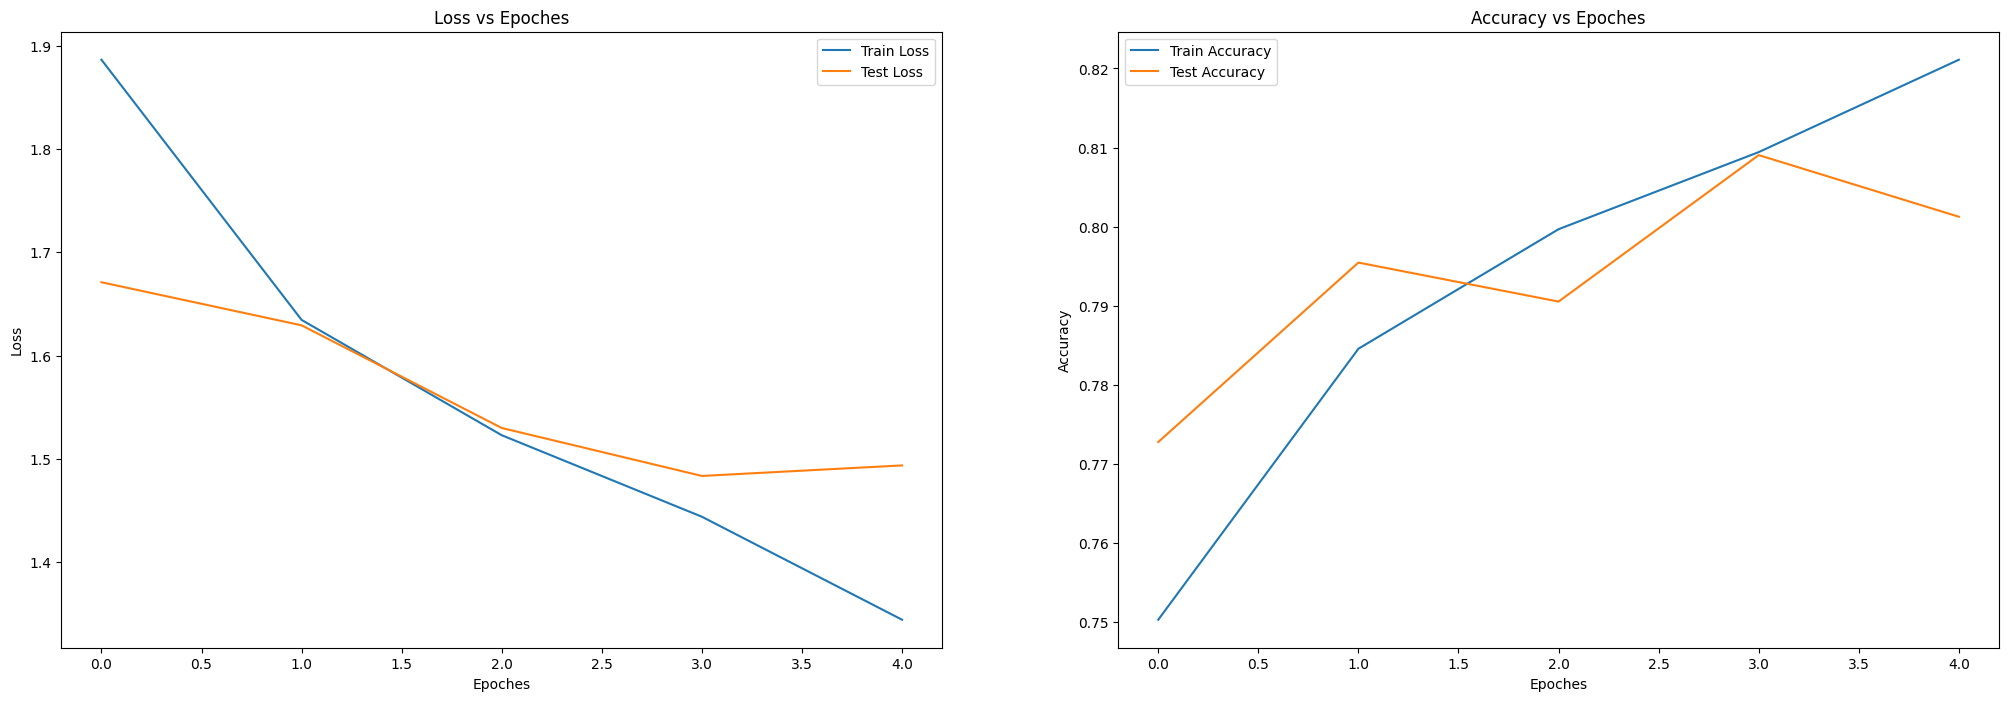

In [25]:
plotplot(train_losses, test_losses, train_acces, test_acces)

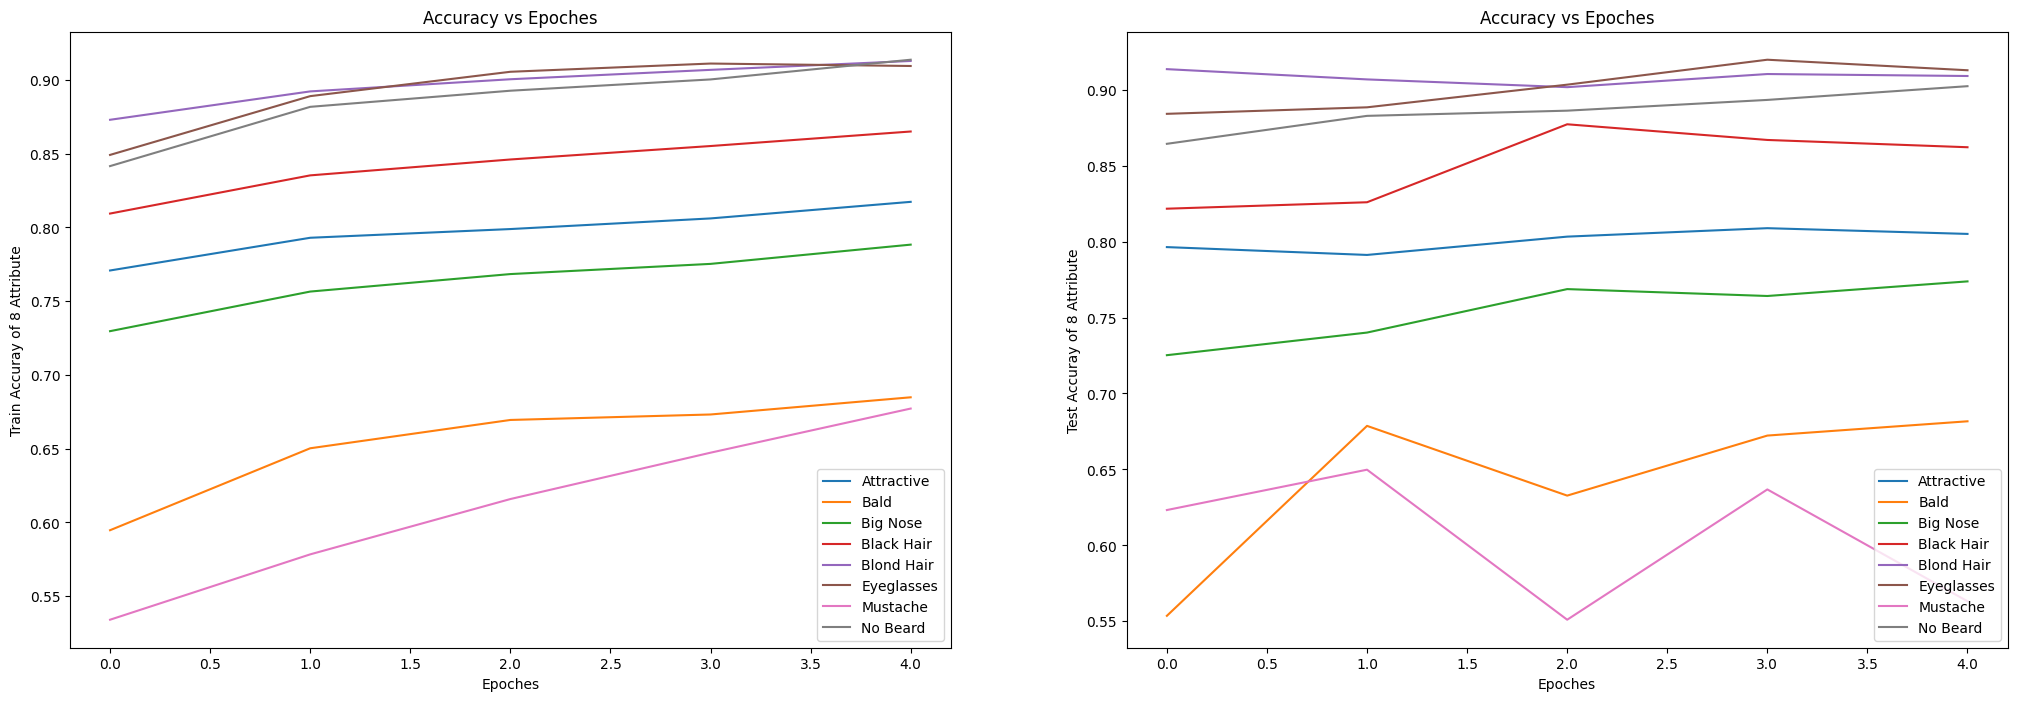

In [26]:
plt.figure(figsize = (25,8))
# plt.plot(range(1, epoches*(len(train_dataloader)*BATCH_SIZE) + 1), train)
plt.subplot(1,2,1)
plt.plot(range(len(tr_acc1_list)),tr_acc1_list, label = "Attractive")
plt.plot(range(len(tr_acc2_list)),tr_acc2_list, label = "Bald")
plt.plot(range(len(tr_acc3_list)),tr_acc3_list, label = "Big Nose")
plt.plot(range(len(tr_acc4_list)),tr_acc4_list, label = "Black Hair")
plt.plot(range(len(tr_acc5_list)),tr_acc5_list, label = "Blond Hair")
plt.plot(range(len(tr_acc6_list)),tr_acc6_list, label = "Eyeglasses")
plt.plot(range(len(tr_acc7_list)),tr_acc7_list, label = "Mustache")
plt.plot(range(len(tr_acc8_list)),tr_acc8_list, label = "No Beard")
plt.xlabel("Epoches")
plt.ylabel("Train Accuray of 8 Attribute")
plt.title("Accuracy vs Epoches")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(tt_acc1_list)),tt_acc1_list, label = "Attractive")
plt.plot(range(len(tt_acc2_list)),tt_acc2_list, label = "Bald")
plt.plot(range(len(tt_acc3_list)),tt_acc3_list, label = "Big Nose")
plt.plot(range(len(tt_acc4_list)),tt_acc4_list, label = "Black Hair")
plt.plot(range(len(tt_acc5_list)),tt_acc5_list, label = "Blond Hair")
plt.plot(range(len(tt_acc6_list)),tt_acc6_list, label = "Eyeglasses")
plt.plot(range(len(tt_acc7_list)),tt_acc7_list, label = "Mustache")
plt.plot(range(len(tt_acc8_list)),tt_acc8_list, label = "No Beard")
plt.xlabel("Epoches")
plt.ylabel("Test Accuray of 8 Attribute")
plt.title("Accuracy vs Epoches")
plt.legend()

plt.show()